# 1. Introduction

The remarkable advances in image recognition technology through Machine Learning algorithims has lead many businesses of different presuaions to seek utilizing its uses. It is applied in areas such as social media image tagging, self-driving car technology, security and medical research. This project aims to assess the accuracy of a built-from-scratch CNN model and a ResNet50 pre-trained transfer learning CNN model in distingushing leukemic B-lymphoblast cells from healthy B-lymphoid precursors. The images are microscopic images of blood smear samples for patients who are healthy and others who have been diagnosed with Leukemia.

# 2. Dataset Information

The dataset was obtained from:<br>
- https://www.kaggle.com/andrewmvd/leukemia-classification<BR>

And the orginal source referenced by the Kaggle.com user is:<br>

- https://biomedicalimaging.org/2019/challenges/<br>

The images are size 450x450x3 and are pre-labeled as either normal or malginant cells. The ground truth was marked by expert oncologists. <br>
These cells have been segmented from the microscopic images and they are representative of images in the real-world in that they contain staining noise and illumination errors. The providers of the dataset have attempted reduce these errors and noise via their own in-house method of stain color normalization.<br>

The dataset contains a total of 118 individual subjects, and are distributed as follows:
- 69 cancer subjects, the images are labelled as **ALL**.<br>
- 49 Normal subjects and the cell images are labelled as **HEM**<br>
- Training set composition:<br>
<BLOCKQUOTE>
    ○ Total subjects: 73 of which 47: ALL and 26:HEM. <br>
    ○ Total microscopic cell images (datapoints): 10,671 of which 7272: ALL and  3389: HEM. <br>
</BLOCKQUOTE>
- Test set composition: Total subjects:<br>
<BLOCKQUOTE>
    ○ Total subjects: 28 of which 13: All and 15: Normal.<br>
    ○ Total microscopic cell images (datapoints): 1867 of which 1219: ALL and648 : HEM. <br>
</BLOCKQUOTE>

Image naming convention follows the order below:<br>
- Cancer cell images' naming UID_P_N_C_all
- Mormal (healthy) cell images' naming UID_HS_N_C_hem


# 3. Convolutional Neural Networks

The way Convolutional Neural Networks (CNN) work is inspired by the human visual cortex which makes it espeically powerful in image and video related processing. Its advantage over Fully Connected Neural Networks lies in the concept of parameter sharing, where a single filter is applied over the input to produce what is known as a feature map. The complexity of the features that are processed increase as more layers are used.

The basic architecture of CNN constitutes of input, hidden and output layers. The input and output layers are similar to other types of Neural Networks. The features that make CNNs what they are are in the hidden layers. The hidden layer will typically be made of:

1. Convolutional layers: <br>
Usually these constitute of sub-layers. The perceptron on each layer are responsible for a a local receptive field only. These are assigned to the input layer and each consecutive sublayer within the convolutional layer. Perceptron will accordingly produce weight matricies (filters) which have the same value for all the perceptron on a sublayer. The output of these filters are known as a Feature Map. (Huang, 2020)
2. Pooling layers: <br>
The ouptput from the convolutional is fed into a pooling layer. As with the convolutional layers, it also consists of sublayers and are usually the same number as the convolutional layer that preceeded it. A perceptron on sublayer of the pooling layer is connected to the ones in the perceptron's receptive field on sublayer of its input convolutional layer. This allows it to subsample a convolutional layer and further reduce the number of parameters in the neural network, and in turn, the time and space complexity. (Huang, 2020)
Similar to the perceptrons on the input layer, the pooling layer's perceptrons do not have weights. However, they use the either a max or mean activation function. A pooling layer that uses max as the activation function is called a Max Pooling Layer and called an Average Pooling Layer when the mean activation function is used. (Huang, 2020)
3. Fully connected layers: <BR>
Here every neuron in one layer is connected to every neuron in the preceeding layer. It is the same as the traditional fully connected multi-layer perceptron neural network FNN. The output from the last pooling layer is flattened in preperation to be classified. <BR>

In this project TensorFlow ML platform and Keras ML API will be used to build the CNN. The code below will build a network from scratch specifically for this dataset as well as use ResNet50 pretrained model. Due to time limitation, the training will be stopped once a validation accuracy score of 80-85%. The author will update this model in the future to achieve higher accuracies. 

-------------------------------
Reference:
Huang, Y, 2020 Fall Semster DATS6202 Lecture Slides.

## 3.1 Data Pre-Processing

#### Mount Google Drive

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Libraries

In [2]:
from scipy import misc
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import os
from os.path import join
from os import listdir
import cv2
import warnings
import re
# Ignore warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting fixed variables

In [3]:
# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# The random seed
random_seed = 9

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [4]:
# Directory to data and colab notebook
abspath_curr = "/content/drive/My Drive/Colab Notebooks/FinalProject/"
data_dir = "/content/drive/My Drive/Colab Notebooks/FinalProject/data/luke/CNMC/"
table_dir = "/content/drive/My Drive/Colab Notebooks/FinalProject/data/luke/"

#### Reading Test Data Table

In [5]:
# Test Dataset table
df = pd.read_csv(table_dir+"C-NMC_test_prelim_phase_data_labels.csv")

In [6]:
df.shape

(1867, 3)

In [7]:
df.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [8]:
labels = 'labels'

In [9]:
# original image size is 450x450 and are colored. For computational cost reasons, this will be reduced to by a factor of 10.
img_size = 45

#### Creating training data

In [10]:
# Splitting data using the paths to the files
folds = []
paths_train = []
paths_test = []
# Training set paths
for fold in ['fold_0/', 'fold_1/','fold_2/']:
  for clas in ['all/', 'hem/']:
    for f in os.listdir(table_dir+'train/'+fold+clas):
      path = os.path.join(table_dir+'train/'+fold+clas, f)
      paths_train.append(path)

# Test set paths
for i,_ in df.iterrows():
    path = os.path.join(data_dir, df.loc[i,'new_names'])
    paths_test.append(path)

In [19]:
# Checking size of data
print(len(paths_train), len(paths_test))

# Check ratio
# 25% percent of training will be used as validation set
print(round(len(paths_test)/ (len(paths_train)*0.75+len(paths_test)),1))

10671 1867
0.2


**Please note that pre-processing code below is time consuming. If you wish to skip the pre-preocessing step there is a code cell below that imports pre-processed data saved as pickle files**

In [12]:
# The code below preprocesses images and extract labels from their file name. HEM indicates it is a healty cell while ALL indicates it is a malignant cell.

# image arrays are resize to 1/10 of original size, kept in color, tagged with their class and appended to a list
training_data = []
for path in paths_train:
  # print(path)
  img_array=cv2.imread(path, cv2.IMREAD_ANYCOLOR)
  #print(img_array)
  new_array=cv2.resize(img_array, (img_size,img_size)) # resize image to 45x45
  if re.findall('\/all\/', path) == ['/all/']: # regex used to detec 'all' in the path which signifiys it is a cancer cell class
    training_data.append([new_array, 1]) # 1 for cancer
  elif re.findall('\/hem\/', path) == ['/hem/']: # regex used to detec 'hem' in the path which signifiys it is a normal cell class
    training_data.append([new_array, 0]) # 0 for healthy
  else:
    # print('check manualy') # error check
    training_data.append([new_array, 'unclassified'])

# using the table, the data labels are assigned to each image file
testing_data = []
for i in range(len(paths_test)):
  # print(paths_test[i])
  img_array=cv2.imread(paths_test[i], cv2.IMREAD_ANYCOLOR) 
  new_array=cv2.resize(img_array, (img_size,img_size)) # resize image to 45x45
  testing_data.append([new_array, df.loc[i,'labels']])

In [20]:
# save processed arrays using pick;e
directory = os.path.dirname(abspath_curr + '/input/pickled_arrays/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# with open(abspath_curr + "/input/pickled_arrays/training.pickle", "wb") as output_file:
#   pickle.dump(training_data, output_file)

In [ ]:
# with open(abspath_curr + "/input/pickled_arrays/testing.pickle", "wb") as output_file:
#   pickle.dump(testing_data, output_file)

In [ ]:
## load preprocessed arrays
with open(abspath_curr + "/input/pickled_arrays/training.pickle", "rb") as output_file:
  training_data = pickle.load(output_file)
with open(abspath_curr + "/input/pickled_arrays/testing.pickle", "rb") as output_file:
  testing_data = pickle.load(output_file)

In [21]:
# Shuffling the training data
import random
random.seed(random_seed)
random.shuffle(training_data)

In [22]:
len(training_data), len(testing_data)

(10671, 1867)

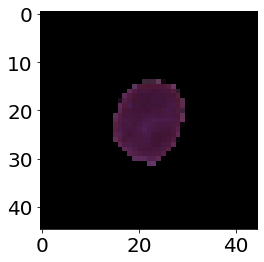

In [23]:
ex1 = training_data[0][0]
plt.imshow(ex1)
plt.show()

In [24]:
# split the images from the labels
X = []
y = []

In [25]:
for features, label in training_data:
    X.append(features)
    y.append(label)

In [26]:
X[0].shape

(45, 45, 3)

In [27]:
y = np.array(y)

In [28]:
# enure image size is the right shape
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [29]:
# scale data
X = X/255.0

In [30]:
X[0].shape

(45, 45, 3)

## 3.2 Training Models

### 3.2.1 CNN Model from Scratch

In [31]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model_cnn/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [32]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 5, activation='relu', padding='same', input_shape=[img_size, img_size, 3]),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 2, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 2, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(256, 2, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 2, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(1,activation='sigmoid')
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 45, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 128)       6

In [34]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',    
              metrics=['accuracy'])

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model_cnn/model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=2)

In [35]:
# Train, evaluate and save the best model
history = model.fit(X,y,
                    epochs=15,
                    validation_split=0.25,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/15
251/251 [==============================] - 66s 264ms/step - loss: 0.5626 - accuracy: 0.7021 - val_loss: 0.5022 - val_accuracy: 0.7732
Epoch 2/15
251/251 [==============================] - 66s 262ms/step - loss: 0.5141 - accuracy: 0.7863 - val_loss: 0.4823 - val_accuracy: 0.7957
Epoch 3/15
251/251 [==============================] - 67s 265ms/step - loss: 0.4913 - accuracy: 0.7916 - val_loss: 0.4706 - val_accuracy: 0.7909
Epoch 4/15
251/251 [==============================] - 66s 263ms/step - loss: 0.4804 - accuracy: 0.7977 - val_loss: 0.4797 - val_accuracy: 0.7965
Epoch 5/15
251/251 [==============================] - 65s 260ms/step - loss: 0.4718 - accuracy: 0.8054 - val_loss: 0.4744 - val_accuracy: 0.7882
Epoch 6/15
251/251 [==============================] - 66s 263ms/step - loss: 0.4584 - accuracy: 0.8133 - val_loss: 0.4455 - val_accuracy: 0.8055
Epoch 7/15
251/251 [==============================] - 65s 259ms/step - loss: 0.4463 - accuracy: 0.8221 - val_loss: 0.4456 - val_ac

In [36]:
# save processed arrays using pick;e
directory = os.path.dirname(abspath_curr + '/result/history/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [37]:
# with open(abspath_curr + "/result/history/history.pickle", "wb") as output_file:
#   pickle.dump(history.history, output_file)

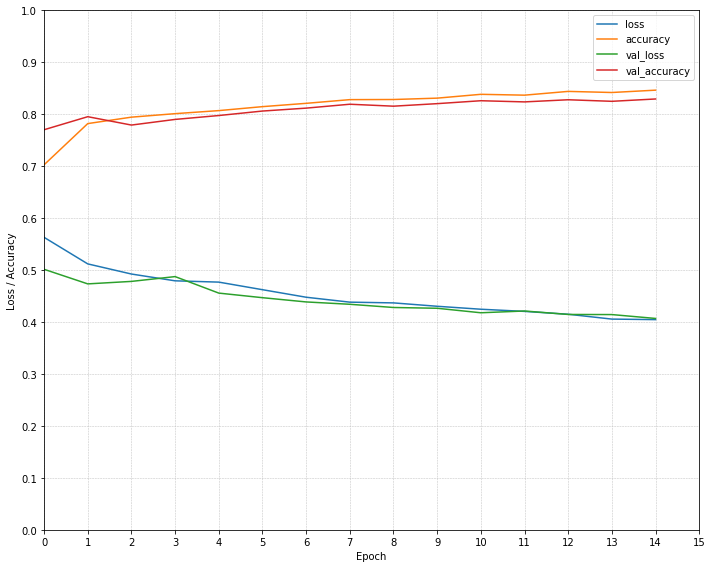

In [18]:
import pandas as pd
# Create a figure
pd.DataFrame(history).iloc[:,0:4].plot(figsize=(10, 8))
plt.grid(color='silver', linestyle='dashed', linewidth=0.5, axis='both')
plt.xlabel('Epoch',color = 'black')
plt.xticks(range(0,16), color = 'black')
plt.ylabel('Loss / Accuracy',color = 'black')
plt.yticks(np.linspace(0,1,11) ,color = 'black')
plt.tight_layout()
plt.show()

### 3.2.2 CNN Model using ResNet50 Pre-trained Model

Here I will use the pre-trained model ResNet50 deep for feature extraction for  transfer Learning.


In [39]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model_resnet/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [40]:
# Add the pretrained layers
pretrained_model1 = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

# Add GlobalAveragePooling2D layer
average_pooling1 = keras.layers.GlobalAveragePooling2D()(pretrained_model1.output)

# Add the output layer
output1 = keras.layers.Dense(1, activation='sigmoid')(average_pooling1)

# Get the model
model1 = keras.Model(inputs=pretrained_model1.input, outputs=output1)

model1.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45, 45, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 23, 23, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 23, 23, 64)   256         conv1_conv[0][0]                 
______________________

In [41]:
# For each layer in the pretrained model
for layer in pretrained_model1.layers:
    # Freeze the layer
    layer.trainable = False

In [42]:
# ModelCheckpoint callback
model_checkpoint_cb1 = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model_resnet/model1.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb1 = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb1 = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=1)

In [43]:
# Compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',    
              metrics=['accuracy'])

In [44]:
# Train, evaluate and save the best model
history1 = model1.fit(X,y,
                    epochs=6,
                    validation_split=0.25,
                    callbacks=[model_checkpoint_cb1,
                               early_stopping_cb1,
                               reduce_lr_on_plateau_cb1])
# Train, evaluate and save the best model

Epoch 1/6
251/251 [==============================] - 77s 307ms/step - loss: 0.6203 - accuracy: 0.6766 - val_loss: 0.5935 - val_accuracy: 0.6863
Epoch 2/6
251/251 [==============================] - 77s 305ms/step - loss: 0.5904 - accuracy: 0.6817 - val_loss: 0.5821 - val_accuracy: 0.6863
Epoch 3/6
251/251 [==============================] - 77s 306ms/step - loss: 0.5648 - accuracy: 0.6904 - val_loss: 0.5584 - val_accuracy: 0.7358
Epoch 4/6
251/251 [==============================] - 74s 294ms/step - loss: 0.5512 - accuracy: 0.7132 - val_loss: 0.5405 - val_accuracy: 0.7136
Epoch 5/6
251/251 [==============================] - 75s 298ms/step - loss: 0.5373 - accuracy: 0.7335 - val_loss: 0.5422 - val_accuracy: 0.7822
Epoch 6/6
251/251 [==============================] - 75s 298ms/step - loss: 0.5285 - accuracy: 0.7552 - val_loss: 0.5297 - val_accuracy: 0.7567


In [45]:
# with open(abspath_curr + "/result/history/history1.pickle", "wb") as output_file:
#   pickle.dump(history1.history, output_file)

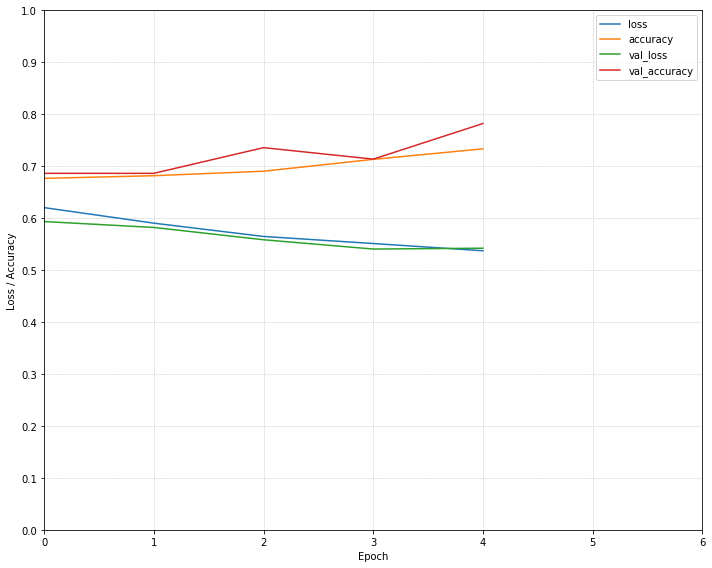

In [20]:
# Create a figure
pd.DataFrame(history1).iloc[:,0:4].plot(figsize=(10, 8))
plt.grid(color='silver', linestyle='dashed', linewidth=0.5, axis='both')
plt.xlabel('Epoch',color = 'black')
plt.xticks(range(0,7), color = 'black')
plt.ylabel('Loss / Accuracy',color = 'black')
plt.yticks(np.linspace(0,1,11) ,color = 'black')
plt.tight_layout()
plt.show()

### 3.2.3 Fine tuning ResNet50

In [47]:
# For each layer in the pretrained model
for layer in pretrained_model1.layers:
    # Unfreeze the layer
    layer.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model1.layers))

Number of layers in the base model:  175


In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model1.layers[:fine_tune_at]:
  layer.trainable =  False

In [50]:
model1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [51]:
# Train, evaluate and save the best model
history1 = model1.fit(X,y,
                    epochs=8,
                    validation_split=0.25,
                    callbacks=[model_checkpoint_cb1,
                               early_stopping_cb1,
                               reduce_lr_on_plateau_cb1])

Epoch 1/8
251/251 [==============================] - 1070s 4s/step - loss: 0.7067 - accuracy: 0.7520 - val_loss: 0.8350 - val_accuracy: 0.3381
Epoch 2/8
251/251 [==============================] - 1084s 4s/step - loss: 0.5260 - accuracy: 0.7835 - val_loss: 0.4659 - val_accuracy: 0.7830
Epoch 3/8
251/251 [==============================] - 1101s 4s/step - loss: 0.4722 - accuracy: 0.8017 - val_loss: 0.5988 - val_accuracy: 0.7691
Epoch 4/8
251/251 [==============================] - 1103s 4s/step - loss: 0.4285 - accuracy: 0.8184 - val_loss: 0.4401 - val_accuracy: 0.8126
Epoch 5/8
251/251 [==============================] - 1078s 4s/step - loss: 0.4151 - accuracy: 0.8228 - val_loss: 0.4386 - val_accuracy: 0.8077
Epoch 6/8
251/251 [==============================] - 1087s 4s/step - loss: 0.4112 - accuracy: 0.8232 - val_loss: 0.4322 - val_accuracy: 0.8141
Epoch 7/8
251/251 [==============================] - 1110s 4s/step - loss: 0.4062 - accuracy: 0.8282 - val_loss: 0.4316 - val_accuracy: 0.8141

In [52]:
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45, 45, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 23, 23, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 23, 23, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# with open(abspath_curr + "/result/history/history1a.pickle", "wb") as output_file:
#   pickle.dump(history1.history, output_file)

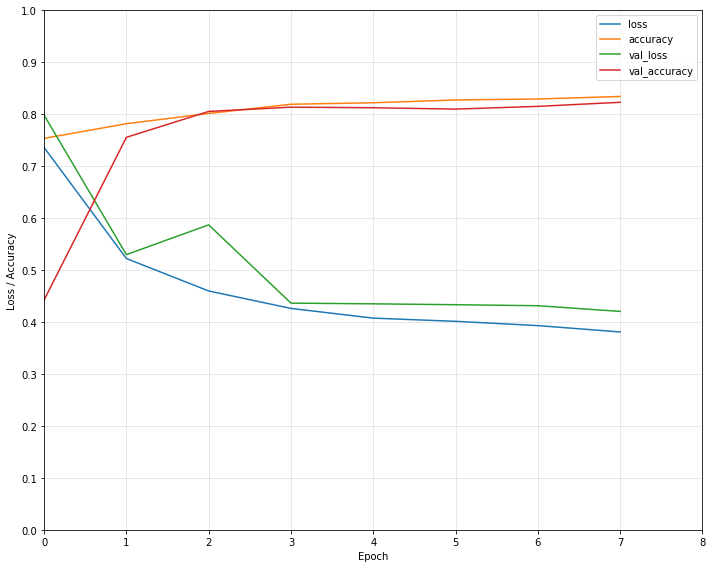

In [23]:
# Create a figure
pd.DataFrame(history1a).iloc[:,0:4].plot(figsize=(10, 8))
plt.grid(color='silver', linestyle='dashed', linewidth=0.5, axis='both')
plt.xlabel('Epoch',color = 'black')
plt.xticks(range(0,9), color = 'black')
plt.ylabel('Loss / Accuracy',color = 'black')
plt.yticks(np.linspace(0,1,11) ,color = 'black')
plt.tight_layout()
plt.show()

## 3.3 Testing Accuracy of Models Using the Testset

### 3.3.1 Pre-processing Testset

In [54]:
X_test = []
y_test = []

In [55]:
for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [56]:
y_test = np.array(y_test)

In [57]:
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
X_test=X_test/255

In [58]:
len(X_test), len(y_test)

(1867, 1867)

In [59]:
type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray)

In [60]:
type(X_test[0]), type(y_test[0])

(numpy.ndarray, numpy.int64)

### 3.3.2 Testing Models

Test using the CNN from scratch model.

In [61]:
model.load_weights(filepath=abspath_curr + '/result/model_cnn/model.h5')

In [62]:
loss, accuracy = model.evaluate(X_test, y_test)

59/59 [==============================] - 3s 55ms/step - loss: 0.6508 - accuracy: 0.7017


Test using the ResNet pretrained model

In [63]:
model1.load_weights(filepath=abspath_curr + '/result/model_resnet/model1.h5')

In [64]:
loss, accuracy = model1.evaluate(X_test, y_test)

59/59 [==============================] - 13s 217ms/step - loss: 0.6722 - accuracy: 0.7043


As seen from the results, the model built from scratch acheived a better validation accuracy than the frozen pretrained ResNet50 model. However, when the ResNet model was unfrozen and allowed to be partially fine tuned, it performed slightly better in the test accuracy score although the total time to train the from-scratch model was shorter. I had to set a limitation of a validation score in the 80% because of time restrictions. However, I believe that if I had more time to train the models and used higher image resolution I would be able to achieve higher accuracy score.